## Sliding window object detection using HOG

### Imports


In [ ]:
from skimage.feature import hog
import numpy as np
import os
from sklearn import svm
from skimage import io, transform
import imutils
import cv2
from google.colab.patches import cv2_imshow
import imutils.object_detection as od

### Compute HOG features

In [ ]:

# set parameters for HOG feature extraction
orientations = 8
pixels_per_cell = (50, 50)
cells_per_block = (2, 2)
visualize = False
normalize = True

# read in deer images and compute HOG features
deer_path = '/content/drive/MyDrive/Classroom/Computer Vision/Q3/tight_crop_deer'
deer_path_no_horn = '/content/drive/MyDrive/Classroom/Computer Vision/Q3/tight_crop_deer_horn_cut'
nondeer_path = '/content/drive/MyDrive/Classroom/Computer Vision/Q3/no_deer'
train_deer_path = '/content/drive/MyDrive/Classroom/Computer Vision/Q3/deer-train'
test_deer_path = '/content/drive/MyDrive/Classroom/Computer Vision/Q3/deer-test'

deer_files = os.listdir(deer_path)
deer_files_nh = os.listdir(deer_path_no_horn)
nondeer_files = os.listdir(nondeer_path)

deer_hogs = []
deer_hogs_nh = []
nondeer_hogs = []

for file in deer_files:
    image = io.imread(deer_path +'/' + file, as_gray=True)
    image_resized = transform.resize(image, (128, 128))
    # compute HOG features
    hog_features = hog(image_resized, orientations=orientations, pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block, visualize=visualize)
    hog_features = np.array(hog_features)
    deer_hogs.append(hog_features)
deer_hogs = np.array(deer_hogs)


for file in deer_files_nh:
    image = io.imread(deer_path +'/'+ file, as_gray=True)
    image_resized = transform.resize(image, (128, 128))
    # compute HOG features
    hog_features = hog(image_resized, orientations=orientations, pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block, visualize=visualize)
    hog_features = np.array(hog_features)
    deer_hogs_nh.append(hog_features)
deer_hogs_nh = np.array(deer_hogs_nh)

for file in nondeer_files:
    image = io.imread(nondeer_path +'/'+ file, as_gray=True)
    image_resized = transform.resize(image, (128, 128))
    # compute HOG features
    hog_features = hog(image_resized, orientations=orientations, pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block, visualize=visualize)
    hog_features = np.array(hog_features)
    nondeer_hogs.append(hog_features)
nondeer_hogs = np.array(nondeer_hogs)

In [ ]:
print(deer_hogs.shape)
print( nondeer_hogs.shape)
print( deer_hogs_nh.shape)

(11, 32)
(10, 32)
(11, 32)


### Build an SVM classifier

In [ ]:
X = np.vstack((deer_hogs, nondeer_hogs))
X_nh = np.vstack((deer_hogs_nh, nondeer_hogs))

y_deer = np.ones((len(deer_hogs),), dtype=int)
y_deer_nh = np.ones((len(deer_hogs_nh),), dtype=int)
y_nondeer = np.zeros((len(nondeer_hogs),), dtype=int)

y_deer = y_deer.reshape( -1, 1)
y_deer_nh = y_deer_nh.reshape( -1, 1)
y_nondeer = y_nondeer.reshape( -1, 1)

y = np.vstack((y_deer, y_nondeer))
y_nh = np.vstack( (y_deer_nh, y_nondeer))

clf = svm.SVC(kernel='poly', degree=3, probability=True)
clf.fit(X, y)

clf_nh = svm.SVC(kernel='poly', degree=3, probability=True)
clf_nh.fit( X_nh, y_nh)

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(kernel='poly', probability=True)

### Sliding window object detection

In [ ]:
test_images = os.listdir( test_deer_path)
test_files = []

for img in test_images:
    if img[-3:]!='jpg':
      continue
    image = cv2.imread(test_deer_path +'/' + img, cv2.IMREAD_GRAYSCALE)
    test_files.append(image)

In [ ]:
test_image = test_files[0]

orientations = 8
pixels_per_cell = (50, 50)
cells_per_block = (2, 2)

def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])


step_size = 8
window_size = (128, 128)

detections = []
detections_nh = []

for (x, y, window) in sliding_window(test_image, step_size, window_size):
    # compute HOG features for window
    hog_features = hog(window, orientations=orientations, pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block)
    probability = clf.predict_proba(hog_features.reshape(1, -1))[0][1]
    probability_nh = clf_nh.predict_proba(hog_features.reshape(1, -1))[0][1]
    # if probability is above a certain threshold, add the detection to the list of detections
    # a value of 0.6 was chosen as anything considerably above that was giving 0 detections
    if probability > 0.6:
        detections.append((x, y, probability))
    if probability_nh > 0.6:
        detections_nh.append( (x, y, probability_nh))



In [ ]:
print(len(detections))
print(len(detections_nh))

2174
18


### Non-maximum suppression

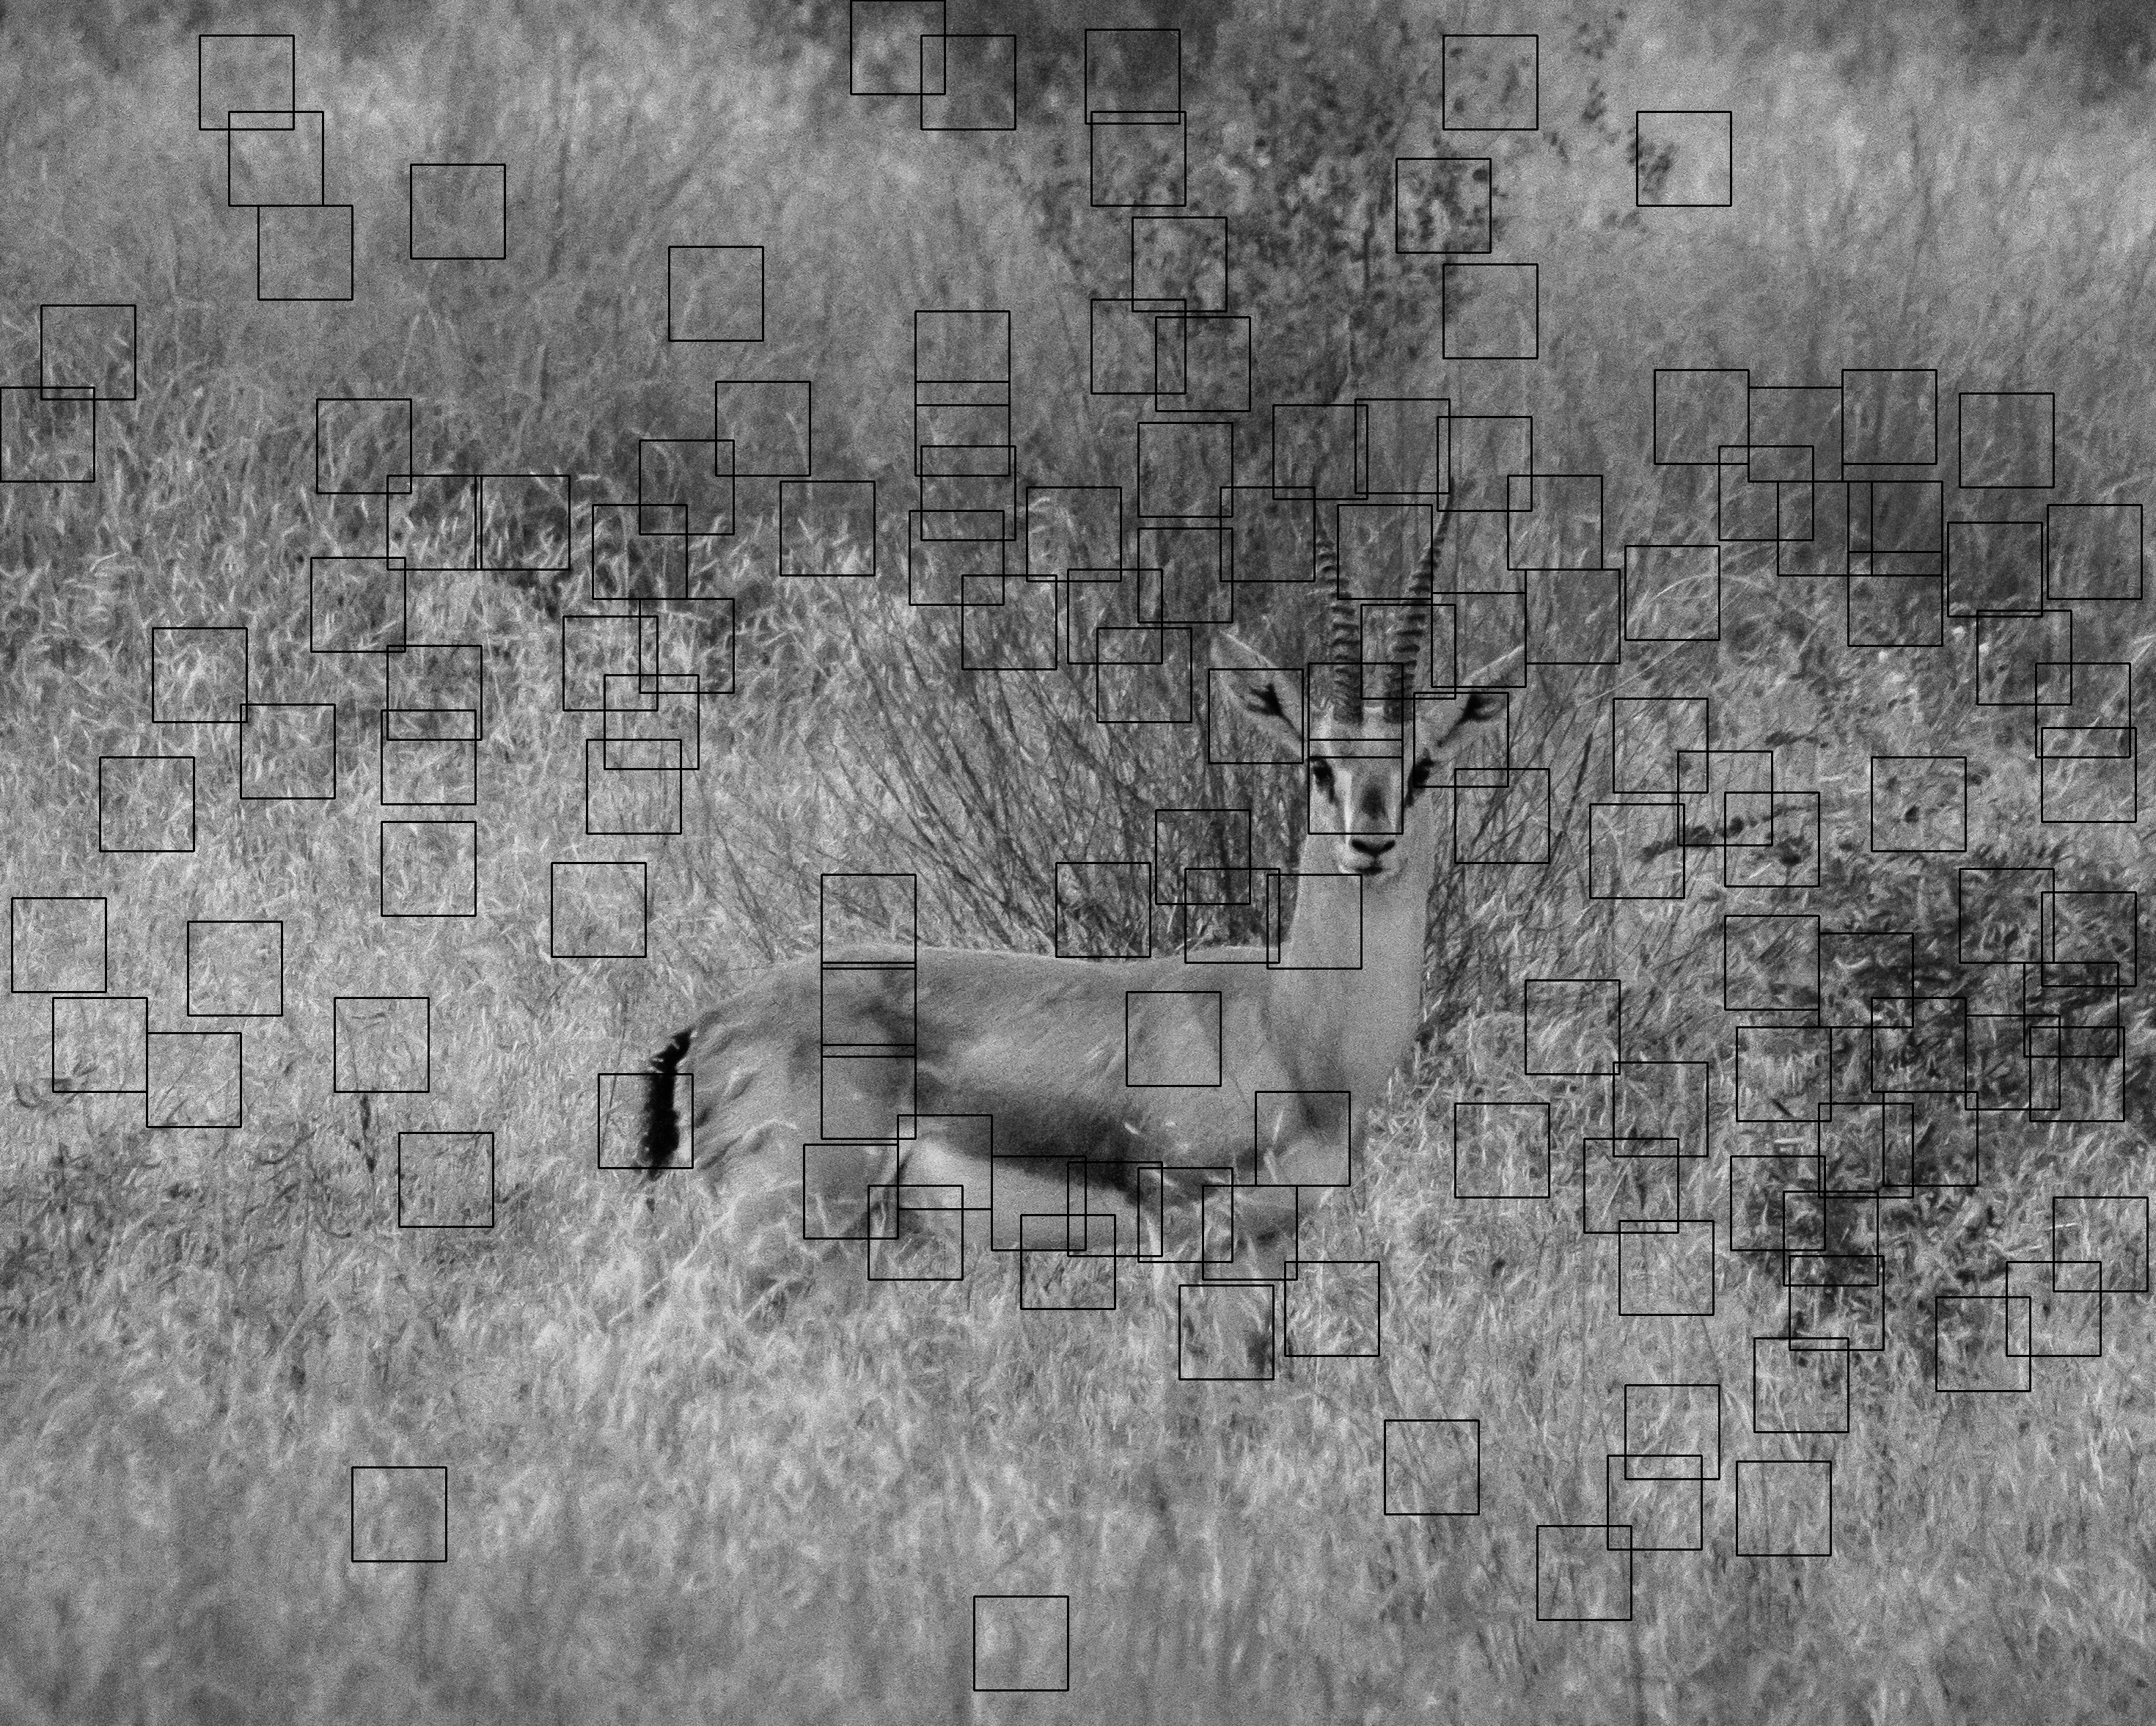

In [ ]:
rects = []
proba = []
for x, y, prob in detections:
  rects.append((x, y, x+128, y+128))
  proba.append(prob)

test_copy = test_image.copy()
boxes = od.non_max_suppression(np.array(rects), probs=proba, overlapThresh=0.3)

for (x1, y1, x2, y2) in boxes:
    cv2.rectangle(test_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)

cv2_imshow(test_copy)


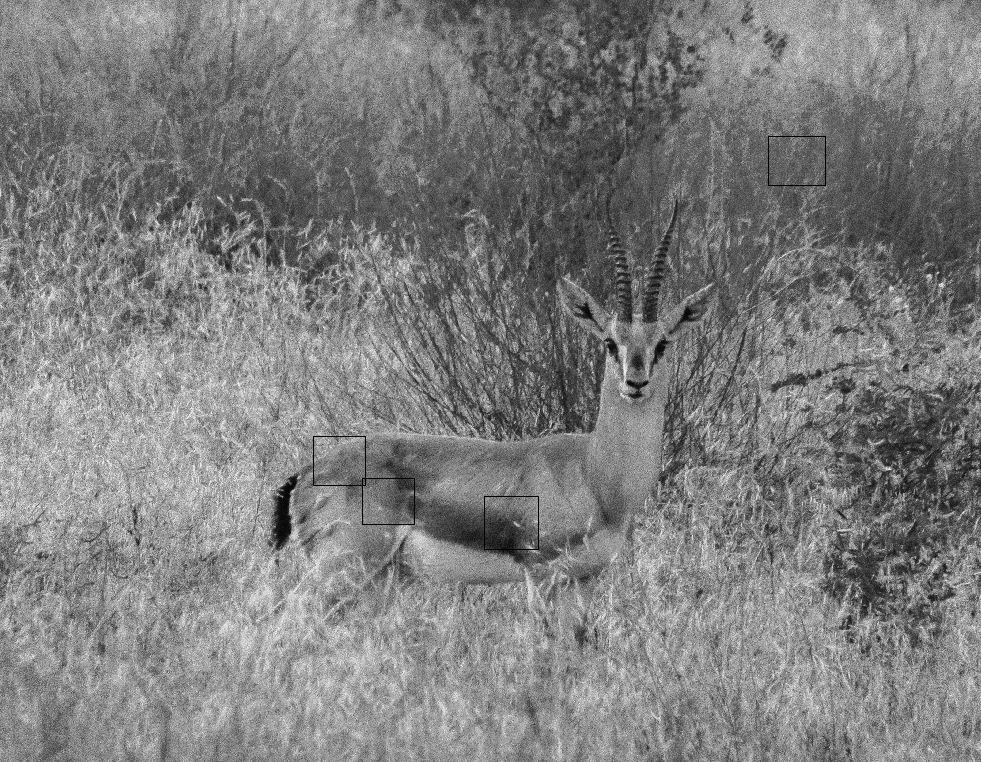

In [ ]:
rects = []
proba = []
for x, y, prob in detections_nh:
  rects.append((x, y, x+128, y+128))
  proba.append(prob)

test_copy = test_image.copy()
boxes = od.non_max_suppression(np.array(rects), probs=proba, overlapThresh=0.3)

for (x1, y1, x2, y2) in boxes:
    cv2.rectangle(test_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)

cv2_imshow(test_copy)


In [ ]:
test_image2 = test_files[1]

orientations = 8
pixels_per_cell = (50, 50)
cells_per_block = (2, 2)

def sliding_window(image, step_size, window_size):
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])


step_size = 8
window_size = (128, 128)

detections = []
detections_nh = []

for (x, y, window) in sliding_window(test_image, step_size, window_size):
    # compute HOG features for window
    hog_features = hog(window, orientations=orientations, pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block)
    probability_nh = clf_nh.predict_proba(hog_features.reshape(1, -1))[0][1]
    # if probability is above a certain threshold, add the detection to the list of detections
    # a value of 0.6 was chosen as anything considerably above that was giving 0 detections
    if probability_nh > 0.6:
        detections_nh.append( (x, y, probability_nh))


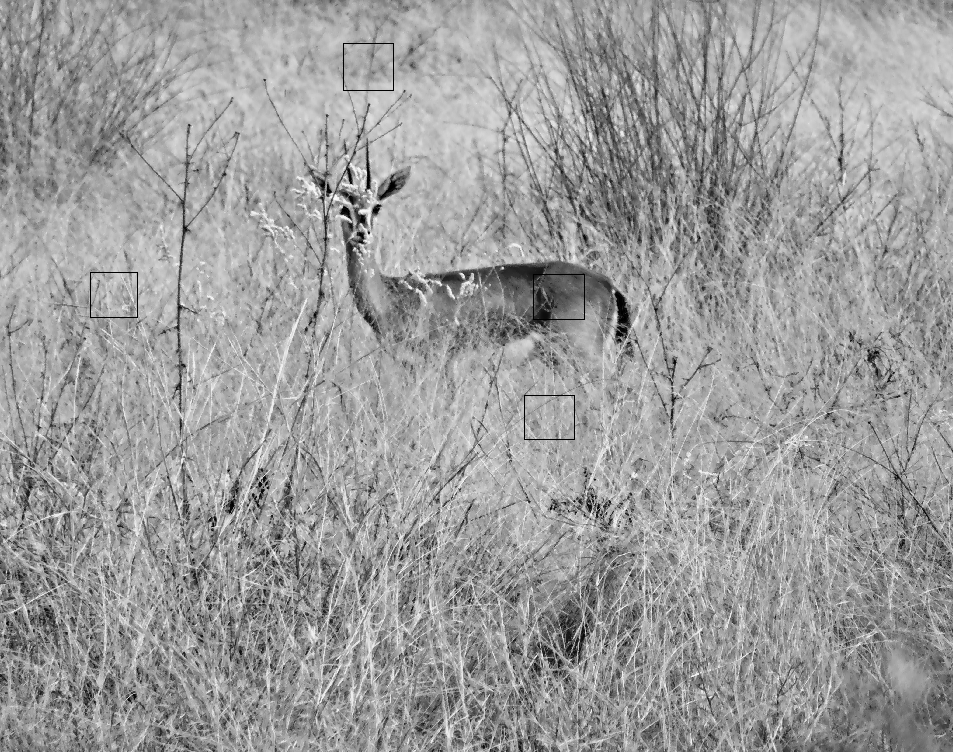

In [ ]:
test_image2 = test_files[1]
rects = []
proba = []
for x, y, prob in detections_nh:
  rects.append((x, y, x+128, y+128))
  proba.append(prob)

test_copy = test_image2.copy()
boxes = od.non_max_suppression(np.array(rects), probs=proba, overlapThresh=0.3)

for (x1, y1, x2, y2) in boxes:
    cv2.rectangle(test_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)

cv2_imshow(test_copy)
